In [2]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import CamembertTokenizer, CamembertModel
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import json

In [16]:
# enregistrer le modèle
def save_model(model, path="model/bert+smote.pt"):
    torch.save(model.state_dict(), path)
    print(f"Modèle enregistré dans {path}")

In [4]:
# charger le modèle
def load_model(BERTClassifier, num_classes, path:str):
    model = BERTClassifier(num_classes=num_classes)
    model.load_state_dict(torch.load(path, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()
    print(f"Modèle chargé depuis : {path}")
    return model

In [5]:
# Hyperparamètres
SEQ_LEN = 128
BATCH_SIZE = 32
EPOCHS = 4
PRETRAINED_MODEL = "camembert-base"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Charger le fichier de mappage
with open("label_mappings.json", "r", encoding="utf-8") as f:
    mappings = json.load(f)
label2Index = mappings["label2Index"]
index2label = {int(k): v for k, v in mappings["index2label"].items()}

In [7]:
df_train = pd.read_csv('train.csv')
df_val = pd.read_csv('val.csv')
df_test = pd.read_csv('test.csv')

In [8]:
# Tokenizer
tokenizer = CamembertTokenizer.from_pretrained(PRETRAINED_MODEL)

In [9]:
# Dataset
class BERTDataset(Dataset):
    def __init__(self, df, tokenizer, seq_len):
        self.texts = df['text'].tolist()
        self.labels = df['labels'].tolist()
        self.seq_len = seq_len
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.seq_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }
    

In [7]:
# Créer Dataset et DataLoader
train_dataset = BERTDataset(df_train, tokenizer, SEQ_LEN)
val_dataset   = BERTDataset(df_val, tokenizer, SEQ_LEN)
test_dataset  = BERTDataset(df_test, tokenizer, SEQ_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [12]:
# BERT + Dropout + Linear
class BERTClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.bert = CamembertModel.from_pretrained(PRETRAINED_MODEL)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # Utiliser le vecteur du token [CLS]
        x = self.dropout(cls_output)
        logits = self.classifier(x)
        return logits

In [13]:
model = BERTClassifier(num_classes=len(label2Index)).to(DEVICE)

In [14]:
# Entrênement
def train(model, train_loader, val_loader, epochs, lr=1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model.to(DEVICE)

    train_accs, val_accs = [], []  # Pour stocker les courbes

    for epoch in range(epochs):
        model.train()
        total_loss, total_correct, total = 0, 0, 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch in loop:
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            preds = torch.argmax(outputs, dim=1)
            correct = (preds == labels).sum().item()

            total_loss += loss.item()
            total_correct += correct
            total += labels.size(0)

            loop.set_postfix({
                "Batch Loss": f"{loss.item():.4f}",
                "Batch Acc": f"{correct / labels.size(0):.4f}"
            })

        # Entraînement terminé pour cette époque
        train_acc = total_correct / total
        train_accs.append(train_acc)

        # Évaluation
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(DEVICE)
                attention_mask = batch['attention_mask'].to(DEVICE)
                labels = batch['labels'].to(DEVICE)

                outputs = model(input_ids, attention_mask)
                preds = torch.argmax(outputs, dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        val_accs.append(val_acc)
        print(f"Epoch {epoch+1} Summary — Loss: {total_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    return train_accs, val_accs

In [11]:
train_accs, val_accs = train(model, train_loader, val_loader, EPOCHS)

Epoch 1/4: 100%|█| 250/250 [24:37<00:00,  5.91s/it, Batch Loss=0.0947, Batch Acc


Epoch 1 Summary — Loss: 62.1368, Train Acc: 0.9044, Val Acc: 0.9790


Epoch 2/4: 100%|█| 250/250 [23:26<00:00,  5.62s/it, Batch Loss=0.0953, Batch Acc


Epoch 2 Summary — Loss: 33.2209, Train Acc: 0.9548, Val Acc: 0.9720


Epoch 3/4: 100%|█| 250/250 [23:42<00:00,  5.69s/it, Batch Loss=0.1105, Batch Acc


Epoch 3 Summary — Loss: 36.8837, Train Acc: 0.9355, Val Acc: 0.9870


Epoch 4/4: 100%|█| 250/250 [23:32<00:00,  5.65s/it, Batch Loss=0.0708, Batch Acc


Epoch 4 Summary — Loss: 29.2708, Train Acc: 0.9491, Val Acc: 0.9860


In [22]:
# plot
def plot_graph(train, val, title):
    plt.plot(train, label='Train')
    plt.plot(val, label='Validation')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

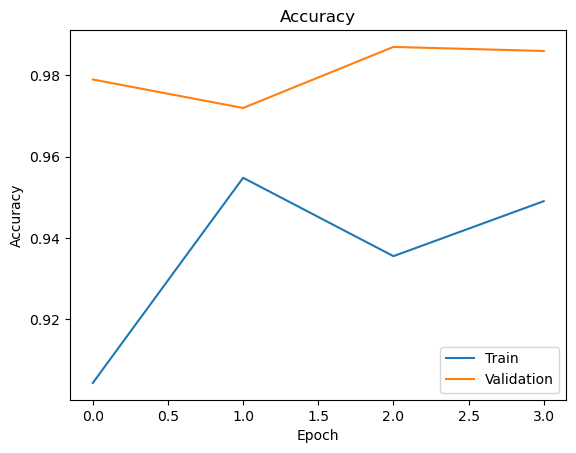

In [13]:
plot_graph(train_accs, val_accs, "Accuracy")

In [21]:
save_model(model)

Modèle enregistré dans model/bert.pt


In [27]:
# Évaluation
def plot_confusion_matrix(y_true, y_pred, labels, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Prédictions")
    plt.ylabel("Véritables")
    plt.tight_layout()
    plt.show()

def evaluate(model, loader, return_errors=False):
    model.eval()
    y_true, y_pred = [], []
    all_texts = loader.dataset.texts
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)

            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)

            y_true.extend(labels.cpu().tolist())
            y_pred.extend(preds.cpu().tolist())
    
    # Mapper les indices aux noms des étiquettes
    y_true = [index2label[i] for i in y_true]
    y_pred = [index2label[i] for i in y_pred]
    labels = list(label2Index.keys()) 
    
    plot_confusion_matrix(y_true, y_pred, labels)
    print("\nClassification Report:\n", classification_report(y_true, y_pred))
    
    if return_errors:
        df = pd.DataFrame({
            "text": all_texts,
            "true_label": y_true,
            "pred_label": y_pred
        })
        df["correct"] = df["true_label"] == df["pred_label"]
        errors_df = df[df["correct"] == False]
    
    return y_true, y_pred, errors_df

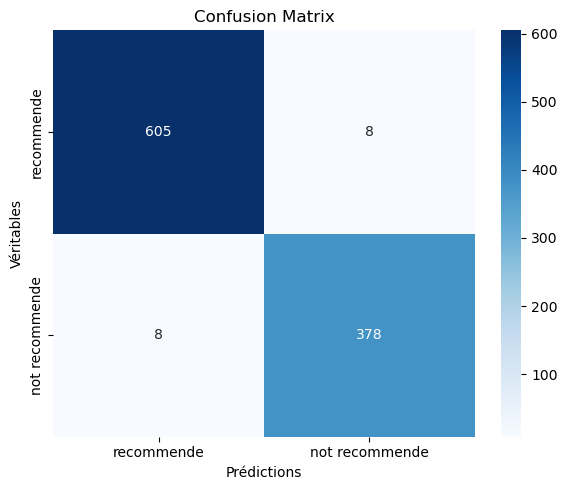


Classification Report:
                 precision    recall  f1-score   support

not recommende       0.98      0.98      0.98       386
    recommende       0.99      0.99      0.99       613

      accuracy                           0.98       999
     macro avg       0.98      0.98      0.98       999
  weighted avg       0.98      0.98      0.98       999



In [30]:
y_true, y_pred, erros_df = evaluate(model, test_loader, True)

In [32]:
erros_df.to_csv("erros.csv")

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

vectorizer = TfidfVectorizer(max_features=5000)  # ou autre méthode, mais pas BERT directement ici
X_tfidf = vectorizer.fit_transform(df_train['text']).toarray()
y = df_train['labels']

# Application de SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

# Reconstruction du DataFrame équilibré
texts_resampled = vectorizer.inverse_transform(X_resampled)
texts_resampled = [" ".join(text) for text in texts_resampled]  # reconvertir en phrases

df_train_balanced = pd.DataFrame({'text': texts_resampled, 'labels': y_resampled})

In [11]:
train_dataset = BERTDataset(df_train_balanced, tokenizer, SEQ_LEN)
val_dataset   = BERTDataset(df_val, tokenizer, SEQ_LEN)
test_dataset  = BERTDataset(df_test, tokenizer, SEQ_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [15]:
train_accs, val_accs = train(model, train_loader, val_loader, EPOCHS)

Epoch 1/4: 100%|█| 307/307 [50:33<00:00,  9.88s/it, Batch Loss=0.2346, Batch Acc


Epoch 1 Summary — Loss: 103.7214, Train Acc: 0.8557, Val Acc: 0.8629


Epoch 2/4: 100%|█| 307/307 [45:42<00:00,  8.93s/it, Batch Loss=0.0394, Batch Acc


Epoch 2 Summary — Loss: 54.4303, Train Acc: 0.9380, Val Acc: 0.9059


Epoch 3/4: 100%|█| 307/307 [37:14<00:00,  7.28s/it, Batch Loss=0.0202, Batch Acc


Epoch 3 Summary — Loss: 28.2013, Train Acc: 0.9702, Val Acc: 0.8969


Epoch 4/4: 100%|█| 307/307 [33:14<00:00,  6.50s/it, Batch Loss=0.2848, Batch Acc


Epoch 4 Summary — Loss: 20.9813, Train Acc: 0.9768, Val Acc: 0.9059


In [17]:
save_model(model)

Modèle enregistré dans model/bert+smote.pt


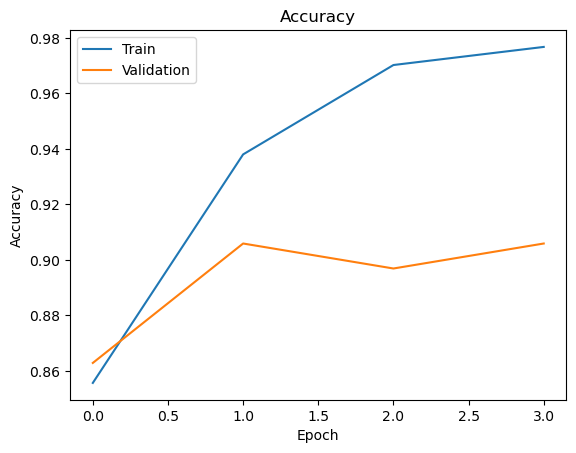

In [23]:
plot_graph(train_accs, val_accs, "Accuracy")

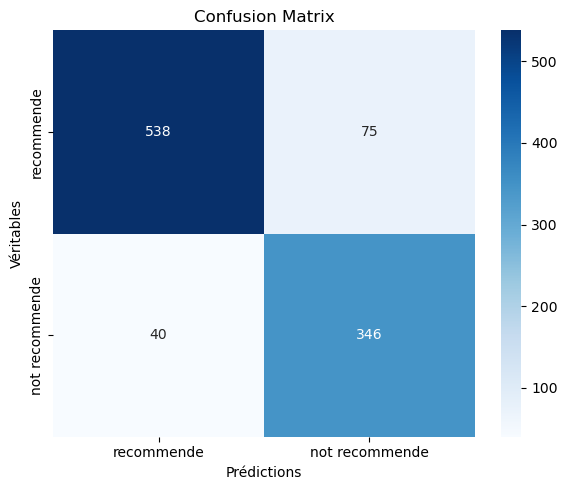


Classification Report:
                 precision    recall  f1-score   support

not recommende       0.82      0.90      0.86       386
    recommende       0.93      0.88      0.90       613

      accuracy                           0.88       999
     macro avg       0.88      0.89      0.88       999
  weighted avg       0.89      0.88      0.89       999



In [20]:
y_true, y_pred = evaluate(model, test_loader)

In [24]:
df_zero_shot = pd.read_csv("Life_is_Strange:_Double_Exposure.csv")
def detect_language(text:str) -> str:
    from langdetect import detect
    from langdetect.lang_detect_exception import LangDetectException
    
    try:
        return detect(str(text))
    except LangDetectException:
        return "unknown"
def filter(df:pd.DataFrame) -> pd.DataFrame:
    df['lang'] = df['comment'].apply(detect_language)
    df_fr = df[df['lang'] == 'fr']
    return df_fr
df_zero_shot = filter(df_zero_shot)
df_zero_shot['label'] = pd.Categorical(df_zero_shot.tag, ordered=True).codes
df_zero_shot.rename(columns={'label': 'labels', 'comment': 'text'}, inplace=True)
df_zero_shot = df_zero_shot[['text', 'labels']]

zs_dataset  = BERTDataset(df_zero_shot, tokenizer, SEQ_LEN)
zs_loader   = DataLoader(zs_dataset, batch_size=BATCH_SIZE)

/tmp/ipykernel_4428/1915325517.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=DEVICE))


Modèle chargé depuis : model/bert.pt


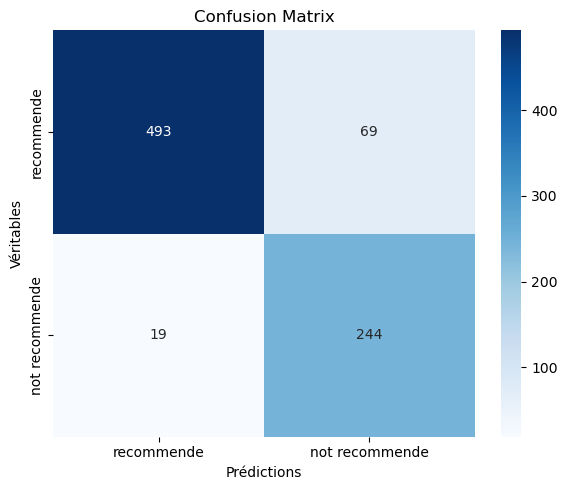


Classification Report:
                 precision    recall  f1-score   support

not recommende       0.78      0.93      0.85       263
    recommende       0.96      0.88      0.92       562

      accuracy                           0.89       825
     macro avg       0.87      0.90      0.88       825
  weighted avg       0.90      0.89      0.90       825



In [25]:
model = load_model(BERTClassifier, len(label2Index), "model/bert.pt")
zs_true, zs_pred = evaluate(model, zs_loader)

/tmp/ipykernel_4428/1915325517.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=DEVICE))


Modèle chargé depuis : model/bert+smote.pt


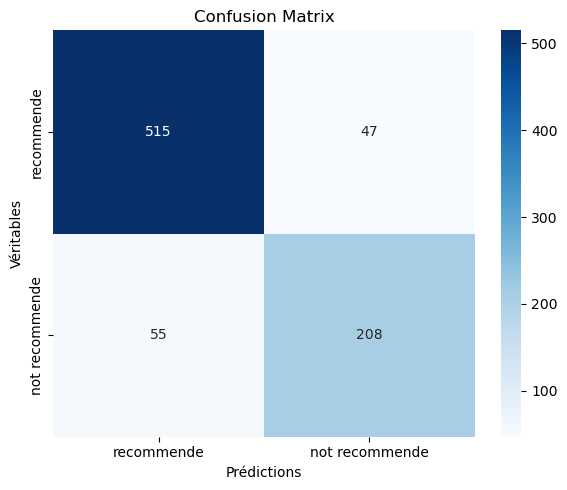


Classification Report:
                 precision    recall  f1-score   support

not recommende       0.82      0.79      0.80       263
    recommende       0.90      0.92      0.91       562

      accuracy                           0.88       825
     macro avg       0.86      0.85      0.86       825
  weighted avg       0.88      0.88      0.88       825



In [26]:
model2 = load_model(BERTClassifier, len(label2Index), "model/bert+smote.pt")
zs_true, zs_pred = evaluate(model, zs_loader)